# Inversion of time-domain airborne electromagnetic data

- Step 1: Load AEM data from `.xyz` file
- Step 2: Read current waveform information from `.gex` file
- Step 3: Create `Survey` object
- Step 4: Discretize 1D vetical mesh
- Step 5: Create a `Simulation` object
- Step 6: Assign data uncertainties (or error)
- Step 7: Design a regularization function
- Step 8: Set up an `Inversion` object and run


## Step 1: Load AEM data from `.xyz` file

We use `libaarhusxyz` for this step. 

In [169]:
import numpy as np
import libaarhusxyz
def read_em_data_from_dat_xyz(em_data, name_gate_times='gate times', dat_type='dat'):
    gate_times = np.array(em_data.info[name_gate_times])
    df_em = em_data.flightlines
    group_em = df_em.groupby('record')
    records = list(group_em.groups.keys())
    df_em_collar = group_em[['line_no','utmx','utmy','timestamp','elevation','alt','tilt']].mean()

    dat_names = ['data_{:d}'.format(ii+1) for ii in range(gate_times.size)]
    df_em[dat_names] = em_data.layer_data['data']
    if dat_type == 'dat':    
        dat_std_names = ['datastd_{:d}'.format(ii+1) for ii in range(gate_times.size)]
        df_em[dat_std_names] = em_data.layer_data['datastd']    

    em_data_nan = em_data.layer_data['data']
    em_data_nan = em_data_nan.replace(9999, np.nan)
    n_ch1_active = np.round((~np.isnan(em_data_nan.loc[df_em[df_em.segment==1].index]).values).sum(axis=1).mean())
    n_ch2_active = np.round((~np.isnan(em_data_nan.loc[df_em[df_em.segment==2].index]).values).sum(axis=1).mean())
    print (f"Active # of channels: Ch1={n_ch1_active:.0f}, Ch2={n_ch2_active:.0f}")

    inds_lm = (~np.isnan(em_data_nan.loc[df_em[df_em.segment==1].index]).values).sum(axis=0) > 0.
    inds_hm = (~np.isnan(em_data_nan.loc[df_em[df_em.segment==2].index]).values).sum(axis=0) > 0.

    data_lm = []
    data_hm = []
    if dat_type == 'dat':
        datastd_lm = []
        datastd_hm = []
    records_inv = []
    for i_record in records:
        df_tmp = group_em.get_group(i_record)
        values = df_tmp[dat_names].values
        if dat_type == 'dat':
            values_std = df_tmp[dat_std_names].values
        if df_tmp.shape[0] == 2:
            i_lm = np.argwhere(df_tmp['segment'].values==1)[0][0]                
            i_hm = np.argwhere(df_tmp['segment'].values==2)[0][0]
            data_lm.append(values[i_lm,inds_lm])
            data_hm.append(values[i_hm,inds_hm])
            if dat_type == 'dat':
                datastd_lm.append(values_std[i_lm,inds_lm])
                datastd_hm.append(values_std[i_hm,inds_hm])        
            records_inv.append(i_record)
    data_lm = np.vstack(data_lm)
    data_hm = np.vstack(data_hm)
    if dat_type == 'dat':
        datastd_lm = np.vstack(datastd_lm)
        datastd_hm = np.vstack(datastd_hm)
    records_inv = np.hstack(records_inv)
    df_em_inv = df_em_collar.loc[records_inv]
    times_lm_inv = gate_times[inds_lm]
    times_hm_inv = gate_times[inds_hm]    

    ch1_names = ['dbdt_ch1gt_{:d}'.format(ii+1) for ii in range(data_lm.shape[1])]
    ch2_names = ['dbdt_ch2gt_{:d}'.format(ii+1) for ii in range(data_hm.shape[1])]
    if dat_type == 'dat':    
        std_ch1_names = ['dbdt_std_ch1gt_{:d}'.format(ii+1) for ii in range(data_lm.shape[1])]
        std_ch2_names = ['dbdt_std_ch2gt_{:d}'.format(ii+1) for ii in range(data_hm.shape[1])]    

    df_em_inv[ch1_names] = data_lm
    df_em_inv[ch2_names] = data_hm
    if dat_type == 'dat':    
        df_em_inv[std_ch1_names] = datastd_lm
        df_em_inv[std_ch2_names] = datastd_hm
    
    meta_data_dict = {}
    meta_data_dict['ch1_names'] = ch1_names
    meta_data_dict['ch2_names'] = ch2_names
    if dat_type == 'dat':    
        meta_data_dict['std_ch1_names'] = std_ch1_names
        meta_data_dict['std_ch2_names'] = std_ch1_names
    meta_data_dict['ch1_times'] = times_lm_inv
    meta_data_dict['ch2_times'] = times_hm_inv
    df_em_inv = df_em_inv.replace(9999, np.nan)
    return df_em_inv, meta_data_dict

In [170]:
fname = "../salinas_2017/MCWD3_SCI1i_MOD_dat.xyz"
aem_data = libaarhusxyz.XYZ(fname)

In [171]:
aem_data

../salinas_2017/MCWD3_SCI1i_MOD_dat.xyz
--------------------------------
                                                                   0
dummy                                                         9999.0
data unit                                             dB/dt [V/Am^4]
data type                                                  DTSKYTEM2
coordinate system                   WGS 84 UTM zone 11N (epsg:32611)
number of layers                                                30.0
model unit                 Resistivity (Ohm-m) / conductivity (mS/m)
length unit                                                    Meter
number of gates                                                 48.0
gate times (s)     [8.42e-06, 1.041e-05, 1.292e-05, 1.641e-05, 2....
source                       ../salinas_2017/MCWD3_SCI1i_MOD_dat.xyz

Soundings: 20467
Flightlines: 149
Maximum layer depth: None
Projection: None
             utmx          utmy
min  67095.173335  4.063489e+06
max  83568.913123  4.08341

In [172]:
df_em_inv, meta_data_dict = read_em_data_from_dat_xyz(aem_data, name_gate_times='gate times (s)')

Active # of channels: Ch1=18, Ch2=25


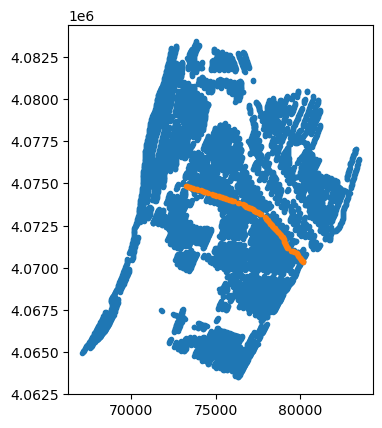

In [314]:
import matplotlib.pyplot as plt
## Pull out required columns from df_em_inv
i_start_lm = 1
i_start_hm = 0
line_all = df_em_inv['line_no'].values
topo_all = df_em_inv[['utmx', 'utmy', 'elevation']].values
line_uniq = np.unique(line_all)
i_line = 4
inds_line = line_all==line_uniq[i_line]

line = df_em_inv['line_no'].values[inds_line]
topo = df_em_inv[['utmx', 'utmy', 'elevation']].values[inds_line, :]
source_heights = df_em_inv['alt'].values[inds_line]
data_lm = df_em_inv[meta_data_dict['ch1_names']].values[inds_line, i_start_lm:]
data_hm = df_em_inv[meta_data_dict['ch2_names']].values[inds_line, i_start_hm:]
data_std_lm = df_em_inv[meta_data_dict['std_ch1_names']].values[inds_line, i_start_lm:]
data_std_hm = df_em_inv[meta_data_dict['std_ch2_names']].values[inds_line, i_start_hm:]
n_sounding = len(line)
times_lm = meta_data_dict['ch1_times'][i_start_lm:]
times_hm = meta_data_dict['ch2_times'][i_start_hm:]
plt.plot(topo_all[:,0], topo_all[:,1], '.')
plt.plot(topo[:,0], topo[:,1], '.')
plt.gca().set_aspect(1)

## Step 2: Read current waveform information from `.gex` file

In [315]:
system = libaarhusxyz.parse_gex("../salinas_2017/20170606_337m2_Cal_DualWaveform_60Hz_414_412_418.gex")
area = system['General']['TxLoopArea']
waveform_hm = system['General']['WaveformHMPoint']
waveform_lm = system['General']['WaveformLMPoint']
time_input_currents_hm = waveform_hm[:,0]
input_currents_hm = waveform_hm[:,1]
time_input_currents_lm = waveform_lm[:,0]
input_currents_lm = waveform_lm[:,1]

header [General] parsed
header [Channel1] parsed
header [Channel2] parsed


## Step 3: Create `Survey` object

In [316]:
print (f"Rx coil low pass filter power: {system['General']['RxCoilLPFilter'][0]}, frequency: {system['General']['RxCoilLPFilter'][1]:.1e} hz")
print (f"Low moment TiB low pass filter power: {system['Channel1']['TiBLowPassFilter'][0]}, frequency: {system['Channel1']['TiBLowPassFilter'][1]:.1e} hz")
print (f"High moment TiB low pass filter power: {system['Channel2']['TiBLowPassFilter'][0]}, frequency: {system['Channel2']['TiBLowPassFilter'][1]:.1e} hz")

Rx coil low pass filter power: 0.99, frequency: 2.1e+05 hz
Low moment TiB low pass filter power: 1.0, frequency: 3.0e+05 hz
High moment TiB low pass filter power: 1.0, frequency: 3.0e+05 hz


In [317]:
source_locations = np.c_[topo[:,0], topo[:,1], topo[:,2]+source_heights]
receiver_locations = np.c_[topo[:,0], topo[:,1]+13.25,  topo[:,2]+source_heights+2]

In [318]:
from discretize import TensorMesh
import SimPEG.electromagnetics.time_domain as tdem

source_list = []
receiver_orientation = 'z'
source_orientation = 'z'
for i_sounding in range(n_sounding):    
    waveform_lm = tdem.sources.PiecewiseLinearWaveform(time_input_currents_lm, input_currents_lm)
    waveform_hm = tdem.sources.PiecewiseLinearWaveform(time_input_currents_hm, input_currents_hm)
    source_location = source_locations[i_sounding, :]
    receiver_location = receiver_locations[i_sounding, :]

    # Receiver list

    dbzdt_receiver_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_location, times_lm, "z",
            lp_cutoff_frequency_1=3e5,
            lp_power_1=1,
            lp_cutoff_frequency_2=2.1e5,
            lp_power_2=0.99,        
    )

    dbzdt_receiver_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_location, times_hm, "z",
            lp_cutoff_frequency_1=3e5,
            lp_power_1=1,
            lp_cutoff_frequency_2=2.1e5,
            lp_power_2=0.99,        
    )

    # Make a list containing all receivers even if just one

    # Must define the transmitter properties and associated receivers

    source_list.append(tdem.sources.MagDipole(
        [dbzdt_receiver_lm],
        location=source_location,
        waveform=waveform_lm,
        orientation=source_orientation,
        i_sounding=i_sounding,
    )
    )
    source_list.append(tdem.sources.MagDipole(
        [dbzdt_receiver_hm],
        location=source_location,
        waveform=waveform_hm,
        orientation=source_orientation,
        i_sounding=i_sounding,
    )
    )


survey = tdem.Survey(source_list)

## Step 4: Discretize 1D vetical mesh

In [319]:
from SimPEG.electromagnetics.utils.em1d_utils import get_vertical_discretization

In [320]:
thicknesses = get_vertical_discretization(30, 2., 1.08)

>> Depth from the surface to the base of the bottom layer is 226.6m


In [321]:
hz = np.r_[thicknesses, thicknesses[-1]]

## Step 5: Create a `Simulation` object

In [322]:
from SimPEG import maps
from pymatsolver import PardisoSolver

In [323]:
n_layer = len(hz)
nP = n_sounding * n_layer
sigma_map = maps.ExpMap(nP=nP)

In [324]:
simulation = tdem.Simulation1DLayeredStitched(
    survey=survey, 
    thicknesses=thicknesses, 
    sigmaMap=sigma_map,
    topo=topo, 
    parallel=True, 
    n_cpu=8, 
    verbose=False, 
    solver=PardisoSolver,
    n_layer=len(hz)
)

### Run a forward modelling to compare the predicted data with the observed data. 

In [325]:
rho_initial = 10.
m0 = np.log(1./rho_initial) * np.ones(nP)
dpred = simulation.dpred(m0)

In [326]:
n_time = times_lm.size + times_hm.size

In [327]:
DPRED = -dpred.reshape((n_sounding, n_time))
dpred_lm = DPRED[:,:len(times_lm)]
dpred_hm = DPRED[:,len(times_lm):]

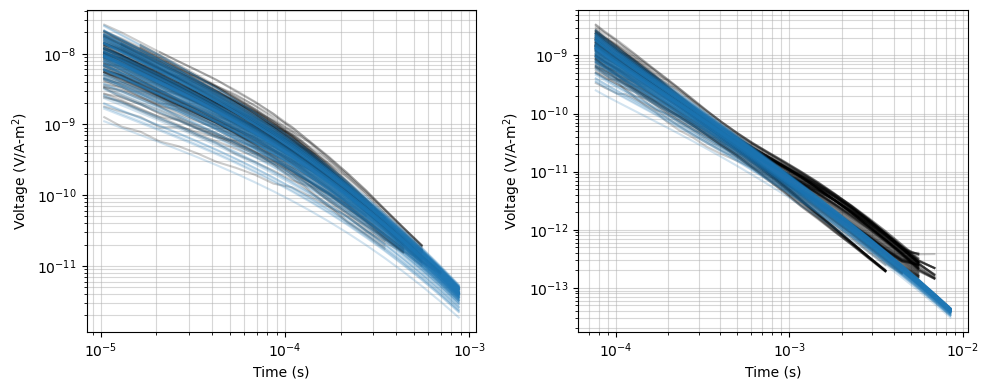

In [328]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
ax1, ax2 = axs
_ = ax1.loglog(times_lm, data_lm.T, 'k', alpha=0.2)
_ = ax1.loglog(times_lm, dpred_lm.T, 'C0', alpha=0.2)
_ = ax2.loglog(times_hm, data_hm.T, 'k', alpha=0.2)
_ = ax2.loglog(times_hm, dpred_hm.T, 'C0', alpha=0.2)

for ax in axs:
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V/A-m$^2$)")
    ax.grid(which='both', alpha=0.5)
plt.tight_layout()

## Step 6: Assign data uncertainties (or error)

In [368]:
import SimPEG
relative_error = 0.03
noise_floor = 1e-14
ignore_value = 9999.
dobs = -np.hstack((data_lm, data_hm)).flatten()
dobs[np.isnan(dobs)] = ignore_value
inds_active_dobs = dobs != 9999.
uncertainties = relative_error*np.abs(dobs) + noise_floor
uncertainties[~inds_active_dobs] = np.inf
# Create data ojbect
data_object = SimPEG.data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
dmis = SimPEG.data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

In [345]:
print (f"Percentage of the active data = {inds_active_dobs.sum()}/{len(dobs)}={inds_active_dobs.sum()/len(dobs)*100:.0f}%")

Percentage of the active data = 5179/5760=90%


## Step 7: Design a regularization function

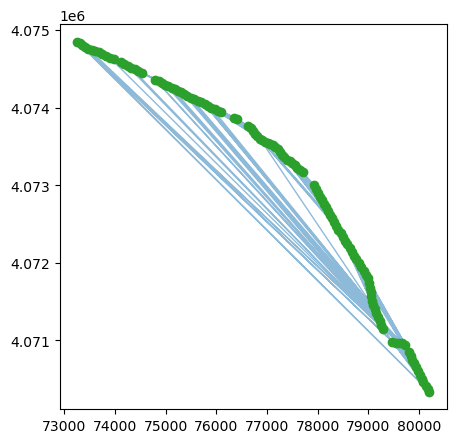

In [369]:
from SimPEG.electromagnetics.utils.em1d_utils import set_mesh_1d
import scipy
from discretize import SimplexMesh
tri = scipy.spatial.Delaunay(topo[:,:2])
mesh_radial = SimplexMesh(tri.points, tri.simplices)
mesh_vertical = set_mesh_1d(hz)
mesh_reg = [mesh_radial, mesh_vertical]

def get_active_edge_indices_with_distance(mesh_radial, mesh_vertical, maximum_distance=1000):
    nz = mesh_vertical.n_cells
    edge_lengths = mesh_radial.edge_lengths
    inds = edge_lengths < maximum_distance
    indActiveEdges = np.tile(inds.reshape([-1,1]), nz).flatten()
    return inds, indActiveEdges

reg = SimPEG.regularization.LaterallyConstrained(
    mesh_reg, 
    mapping=SimPEG.maps.IdentityMap(nP=nP),
    alpha_s = 1e-5,
    alpha_r = 1.,
    alpha_z = 1./2.,
    indActiveEdges=indActiveEdges,
)

fig = plt.figure(figsize=(5, 5))
plt.triplot(topo[:,0], topo[:,1], tri.simplices[:,:], alpha=0.5, lw=1)
plt.plot(topo[:,0], topo[:,1], 'o')
inds, indActiveEdges = get_active_edge_indices_with_distance(
    mesh_radial, mesh_vertical, maximum_distance=50.
)

## Step 8: Set up an `Inversion` object and run

In [360]:

opt = SimPEG.optimization.ProjectedGNCG(maxIter=10, maxIterCG=50)
invProb = SimPEG.inverse_problem.BaseInvProblem(dmis, reg, opt)
beta = SimPEG.directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = SimPEG.directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = SimPEG.directives.TargetMisfit(chifact=1.)
save_model_dict = SimPEG.directives.SaveOutputDictEveryIteration()

inv = SimPEG.inversion.BaseInversion(
    invProb, 
    directiveList=[betaest, beta, target, save_model_dict]
)
invProb.counter = opt.counter = SimPEG.utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [361]:
mest = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.27e+01  1.10e+05  0.00e+00  1.10e+05    9.76e+03      0              
   1  3.64e+01  4.26e+04  3.39e+01  4.39e+04    1.90e+04      0              
   2  1.82e+01  1.62e+04  3.55e+01  1.69e+04    4.46e+03      0              
   3  9.09e+00  1.22e+04  5.06e+01  1.27e+04    5.18e+03      1              
   4  4.55e+00  8.26e+03  8.80e+01  8.66e+03    1.95e+03      0   Skip BFGS  
   5  2.27e+00  7.91e+03  9.05e+01  8.12e+03    2.22e+03      2              
   6  1.14e+00  7.51e+03  1.32e+02  7.66e+03    3.36e+03  

## Step 9: Save inversion results

In [375]:
import dill
dill.dump(save_model_dict.outDict, open("inversion_results.pik", "wb"))